In [1]:
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
G = nx.barbell_graph(3, 0)
nx.draw(G, with_labels = True)
nx.community.modularity(G, nx.community.label_propagation_communities(G))

Changing the Spearman p-values based on modularity won't affect the differential networks, since we only look at the Spearman correlation coefficients for the permutations. I think it only changes the network visualisation step, as well as the visualisation for the integrated stage.

### Testing modularity for networks with all samples included:

In [2]:
proteomic = nx.read_gml("Cytoscape/proteomic_prefiltered.gml")
metabolomic = nx.read_gml("Cytoscape/metabolomic_prefiltered.gml")

In [ ]:
proteomic = nx.read_gml("Cytoscape/proteomic_prefiltered_commoncases.gml")
metabolomic = nx.read_gml("Cytoscape/metabolomic_prefiltered_commoncases.gml")

In [4]:
metabolomic.edges(data=True)

EdgeDataView([('R-HSA-110331', 'R-HSA-112310', {'Squared_corr': 0.1223863405383179, 'Spearman_pval': 5.648917902605013e-05, 'Overlap_coef': 0.0}), ('R-HSA-110331', 'R-HSA-112311', {'Squared_corr': 0.1517675453094209, 'Spearman_pval': 5.993607179154957e-07, 'Overlap_coef': 0.0}), ('R-HSA-110331', 'R-HSA-112315', {'Squared_corr': 0.24818791076323451, 'Spearman_pval': 6.852980837544296e-14, 'Overlap_coef': 0.0}), ('R-HSA-110331', 'R-HSA-1237112', {'Squared_corr': 0.5594772211139739, 'Spearman_pval': 2.336483648353038e-44, 'Overlap_coef': 0.5}), ('R-HSA-110331', 'R-HSA-1368082', {'Squared_corr': 8.959501157696073e-05, 'Spearman_pval': 1.0, 'Overlap_coef': 0.0}), ('R-HSA-110331', 'R-HSA-1368108', {'Squared_corr': 8.959501157696073e-05, 'Spearman_pval': 1.0, 'Overlap_coef': 0.0}), ('R-HSA-110331', 'R-HSA-1428517', {'Squared_corr': 0.0069851095520463554, 'Spearman_pval': 1.0, 'Overlap_coef': 0.0}), ('R-HSA-110331', 'R-HSA-1483148', {'Squared_corr': 0.04497153076871304, 'Spearman_pval': 1.0, '

### Testing modularity on fully connected graph

In [3]:
color_scheme = ["blue","orange","green","purple","red","black","pink","yellow"]

def supply_colours (network_copy,clusters):
    color_map = []
    for node in network_copy:
        for index in range(len(clusters)):
            if node in clusters[index]:
                color_map.append(color_scheme[index])
    return(color_map)

In [15]:
clusters = nx.community.louvain_communities(metabolomic,weight='Spearman_pval',seed=100,resolution=1)
print(len(clusters))

3


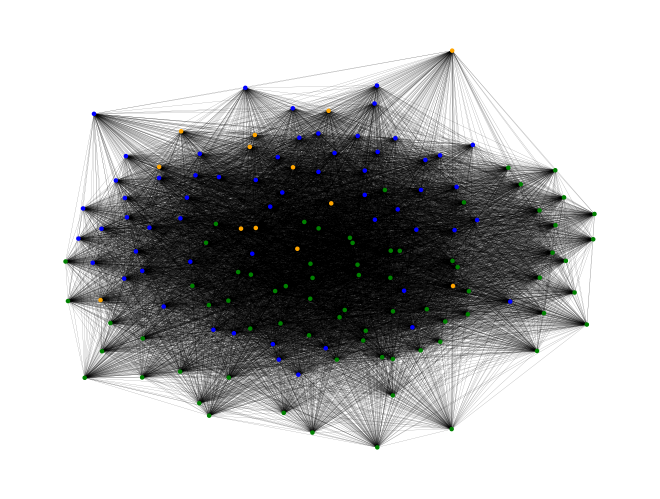

In [17]:
color_map = supply_colours(metabolomic,clusters)
nx.draw(metabolomic, node_size = 5,node_color=color_map,pos=nx.spring_layout(metabolomic,weight="Spearman_pval"), with_labels=False,width=0.07)

In [25]:
#Does not work with a fully connected graph...
nx.community.modularity(metabolomic, nx.community.label_propagation_communities(metabolomic))

#...unless you supply the weights
nx.community.modularity(metabolomic, communities = clusters,weight="Squared_corr")
                        

0.04045691656287336

### Filtering by Spearman p-value

In [ ]:
#Example code: Testing modularity 
edges_to_remove = [(u,v) for u,v,e in proteomic.edges(data=True) if e['Spearman_pval'] >= 0.05]
proteomic.remove_edges_from(edges_to_remove)
nx.community.modularity(proteomic, nx.community.label_propagation_communities(proteomic))

In [ ]:
def modularity_test(omics_type,val):
    network_copy =  omics_type.copy()
    edges_to_remove = [(u,v) for u,v,e in omics_type.edges(data=True) if e['Spearman_pval'] >= val]
    network_copy.remove_edges_from(edges_to_remove)
    #print(len(edges_to_remove))
    return (nx.community.modularity(network_copy, nx.community.label_propagation_communities(network_copy)))

In [ ]:
#x = np.logspace(-5.0, -1.2, num=20)  
x = np.logspace(-24, -22, num=20)  
#x = np.logspace(-45, -40, num=20)  
y = []

for val in x:
    y.append(modularity_test(proteomic,val))

print(x)
print(y)

In [ ]:
modularity_test(metabolomic,0.005)   #0.0062

### Testing whether the clustering method is working as expected

In [ ]:
network_copy =  metabolomic.copy()
edges_to_remove = [(u,v) for u,v,e in network_copy.edges(data=True) if e['Spearman_pval'] >= 0.0005]
network_copy.remove_edges_from(edges_to_remove)

#clusters = list(nx.community.label_propagation_communities(network_copy))  #not ideal since cannot supply Spearman correlation coefs as weights
clusters = nx.community.louvain_communities(network_copy,weight='Squared_corr',seed=100)
print(len(clusters))

nx.draw(network_copy, node_size = 5,node_color=color_map,pos=nx.spring_layout(network_copy,weight="Squared_corr"), with_labels=False,width=0.07)

All samples: <br>
When filtering at p-val < 0.005 for metabolomic data, modularity is 0.0062, proteomic data reaches this value at roughly p_val < 3.79 e-44 

Common cases (128 cases): <br>
When filtering at p-val < 0.005 for metabolomic data, modularity is 0.182, proteomic data reaches this value at roughly p_val < 6.95 e-24

### Scatterplot for omics networks with whole dataset (samples unfiltered regardless of lack of overlap)

In [ ]:
x = np.logspace(-100, -1.2, num=50) 
proteomic_y = []
metabolomic_y = []

for val in x:
    proteomic_y.append(modularity_test(proteomic,val))
    metabolomic_y.append(modularity_test(metabolomic,val))


In [ ]:
log_x = -np.log10(x)

In [ ]:

pval_df = pd.DataFrame({'proteomic' : proteomic_y, 'metabolomic': metabolomic_y})
pval_df.index = log_x
pval_df_long = pval_df.stack().reset_index()
pval_df_long = pval_df_long.rename(columns={'level_0': 'Spearman p-value', 'level_1': 'omics type', 0 : 'modularity'})


pval_df_long

In [ ]:
sns.lineplot(pval_df_long,x = "Spearman p-value", y = "modularity",  hue = "omics type")      

plt.title('Comparison of omics modularity with whole dataset',fontsize=16)
plt.xlabel("Spearman p-values (-log10)",fontsize=13, labelpad=5)
plt.ylabel("Modularity",fontsize=13, labelpad=10) 

plt.axvline(x=-np.log10(0.005), color='red', linewidth=0.8, linestyle='--', dashes=(8, 5))
plt.text(3, 0.75, "p-val = 0.005",fontsize=10)

#Approximate p-value where the two lines cross
plt.axvline(x=-np.log10(0.28e-25), color='black', linewidth=0.5, linestyle='--', dashes=(8, 5))
plt.text(21, 0.65, "p-val = 0.28e-25",fontsize=10)

plt.savefig('Figures/modularity_all.png' ,dpi=200,bbox_inches = 'tight' , pad_inches = 0.2 , facecolor='w')

### Scatterplot for omics networks subset to common cases (128 cases)

In [ ]:
x = np.logspace(-50, -1.2, num=50) 
proteomic_y = []
metabolomic_y = []

for val in x:
    proteomic_y.append(modularity_test(proteomic,val))
    metabolomic_y.append(modularity_test(metabolomic,val))


In [ ]:
log_x = -np.log10(x)

In [ ]:

pval_df = pd.DataFrame({'proteomic' : proteomic_y, 'metabolomic': metabolomic_y})
pval_df.index = log_x
pval_df_long = pval_df.stack().reset_index()
pval_df_long = pval_df_long.rename(columns={'level_0': 'Spearman p-value', 'level_1': 'omics type', 0 : 'modularity'})


pval_df_long

In [ ]:
print(x)
print(log_x)

In [ ]:
sns.lineplot(pval_df_long,x = "Spearman p-value", y = "modularity",  hue = "omics type")      

plt.title('Comparison of omics modularity for common cases',fontsize=16)
plt.xlabel("Spearman p-values (-log10)",fontsize=13, labelpad=5)
plt.ylabel("Modularity",fontsize=13, labelpad=10) 

plt.axvline(x=-np.log10(0.005), color='red', linewidth=0.8, linestyle='--', dashes=(8, 5))
plt.text(3, 0.75, "p-val = 0.005",fontsize=10)

#Approximate p-value where the two lines cross
plt.axvline(x=-np.log10(0.18e-25), color='black', linewidth=0.5, linestyle='--', dashes=(8, 5))
plt.text(21, 0.65, "p-val = 0.18e-25",fontsize=10)

plt.axvline(x=-np.log10(0.8e-33), color='black', linewidth=0.5, linestyle='--', dashes=(8, 5))
plt.text(30, 0.75, "p-val = 0.8e-33",fontsize=10)

#plt.savefig('Figures/modularity_commoncases.png' ,dpi=200,bbox_inches = 'tight' , pad_inches = 0.2 , facecolor='w')

### Filtering by overlap coefficient

In [ ]:
def modularity_test(omics_type,val):
    network_copy =  omics_type.copy()
    edges_to_remove = [(u,v) for u,v,e in omics_type.edges(data=True) if (e['Overlap_coef'] >= val)]
    network_copy.remove_edges_from(edges_to_remove)
    print(len(edges_to_remove))
    return (nx.community.modularity(network_copy, nx.community.label_propagation_communities(network_copy)))

In [ ]:
metabolomic.edges(data=True)


In [ ]:
modularity_test(metabolomic,0.1)

In [ ]:
modularity_test(proteomic,0.1)

Modularity remains at zero for both omics networks even when filtering out edges of overlap coefficient > 0.1 (not sure why, I guess because nearly values are at zero). This is true for both the networks with all samples, and the ones with the common samples only (since the overlap coefficient doesn't change).

In [ ]:
proteomic = nx.read_gml("Cytoscape/proteomic_prefiltered.gml")